In [1]:
# make synthetic dataset

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras # hmm

In [3]:
n_samples = 100

In [4]:
# how the training/dev/test data is distributed
def y_gen(x):
    return np.maximum(x, 0)

# how the production data is distributed
def y_gen_prod(x):
    return 0.5 * np.maximum(x, 0)


def y_obs(x, f):
    y = f(x)
    return y + np.random.normal(0, 0.3, size = len(y))

In [5]:
x = np.random.uniform(-5, 5, size = n_samples)
y = y_obs(x, y_gen)

x_underlying = np.linspace(-5, 5, num = n_samples)
y_underlying = y_gen(x_underlying)

In [6]:
x_prod = np.random.uniform(-5, 5, size = n_samples)
y_prod = y_obs(x_prod, f = y_gen_prod)

x_underlying_prod = np.linspace(-5, 5, num = n_samples)
y_underlying_prod = y_gen_prod(x_underlying)

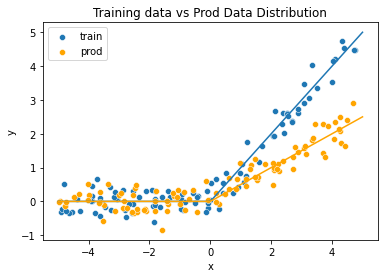

In [7]:
plt.title('Training data vs Prod Data Distribution')

# training data 
sns.scatterplot(x = x, y = y, label = 'train')
sns.lineplot(x = x_underlying, y = y_underlying)

# prod data
sns.scatterplot(x = x_prod, y = y_prod, label = 'prod', color = 'orange')
sns.lineplot(x = x_underlying_prod, y = y_underlying_prod, color = 'orange')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

In [21]:
model = keras.Sequential(
    [
        keras.Input(shape = (1,)),
        keras.layers.Dense(2, activation="relu", name="layer1"),
        keras.layers.Dense(1, name="layer2")
    ]
)

In [22]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [23]:
hist = model.fit(
    x = x.reshape(-1, 1),
    y = y,
    epochs = 600
)

Epoch 1/600
4/4 [==============================] - 0s 2ms/step - loss: 1.4478
Epoch 2/600
4/4 [==============================] - 0s 2ms/step - loss: 1.3865
Epoch 3/600
4/4 [==============================] - 0s 2ms/step - loss: 1.3323
Epoch 4/600
4/4 [==============================] - 0s 2ms/step - loss: 1.2735
Epoch 5/600
4/4 [==============================] - 0s 2ms/step - loss: 1.2195
Epoch 6/600
4/4 [==============================] - 0s 2ms/step - loss: 1.1714
Epoch 7/600
4/4 [==============================] - 0s 2ms/step - loss: 1.1225
Epoch 8/600
4/4 [==============================] - 0s 2ms/step - loss: 1.0763
Epoch 9/600
4/4 [==============================] - 0s 2ms/step - loss: 1.0332
Epoch 10/600
4/4 [==============================] - 0s 2ms/step - loss: 0.9896
Epoch 11/600
4/4 [==============================] - 0s 2ms/step - loss: 0.9469
Epoch 12/600
4/4 [==============================] - 0s 2ms/step - loss: 0.9028
Epoch 13/600
4/4 [==============================] - 0s 2ms/st

4/4 [==============================] - 0s 2ms/step - loss: 0.1038
Epoch 104/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1035
Epoch 105/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1031
Epoch 106/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1028
Epoch 107/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1025
Epoch 108/600
4/4 [==============================] - ETA: 0s - loss: 0.088 - 0s 2ms/step - loss: 0.1022
Epoch 109/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 110/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1016
Epoch 111/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 112/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1011
Epoch 113/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 114/600
4/4 [==============================] - 0s 2ms/step - loss: 0.1003
Epoch 115/600
4/4 [===========

Epoch 205/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0883
Epoch 206/600
4/4 [==============================] - 0s 3ms/step - loss: 0.0883
Epoch 207/600
4/4 [==============================] - 0s 3ms/step - loss: 0.0882
Epoch 208/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 209/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 210/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 211/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0880
Epoch 212/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0880
Epoch 213/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0879
Epoch 214/600
4/4 [==============================] - ETA: 0s - loss: 0.119 - 0s 3ms/step - loss: 0.0879
Epoch 215/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0879
Epoch 216/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0878
Epoch 217/600
4/

4/4 [==============================] - 0s 2ms/step - loss: 0.0857
Epoch 307/600
4/4 [==============================] - 0s 3ms/step - loss: 0.0857
Epoch 308/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 309/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 310/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 311/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 312/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 313/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0857
Epoch 314/600
4/4 [==============================] - 0s 3ms/step - loss: 0.0855
Epoch 315/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 316/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 317/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 318/600
4/4 [==============================] - 0

Epoch 408/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 409/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 410/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 411/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 412/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 413/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 414/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 415/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 416/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 417/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 418/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 419/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 420/600
4/4 [=====================

4/4 [==============================] - 0s 2ms/step - loss: 0.0846
Epoch 511/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 512/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 513/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 514/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0848
Epoch 515/600
4/4 [==============================] - ETA: 0s - loss: 0.110 - 0s 2ms/step - loss: 0.0849
Epoch 516/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 517/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 518/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0848
Epoch 519/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 520/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 521/600
4/4 [==============================] - 0s 2ms/step - loss: 0.0846
Epoch 522/600
4/4 [===========

In [24]:
y_pred = model.predict(x_underlying)[:, 0]

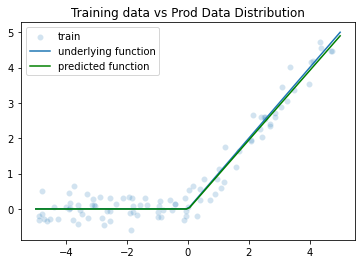

In [26]:
plt.title('Training data vs Prod Data Distribution')

# training data 
sns.scatterplot(x = x, y = y, label = 'train', alpha = 0.2)
sns.lineplot(x = x_underlying, y = y_underlying, label = 'underlying function')

# pred data 
sns.lineplot(x = x_underlying, y = y_pred, label = 'predicted function', color = 'green')

plt.show()